<a href="https://www.kaggle.com/code/leilamaritim/gen-ai-intensive-course-capstone-2025q1-leila?scriptVersionId=234908853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Generative AI application in Humanitarian and Crisis Response

While reflecting on the possibilities of Generative AI (GenAI), I began to consider how I could combine my background in geodata science with the power of GenAI to address real-world challenges. One area that stood out is disaster response, a field where timely, reliable information can save lives.

Read more on my [Medium blog](https://medium.com/@chepkemoileila39/generative-ai-application-in-humanitarian-and-crisis-response-731916a2da4a)


In [1]:
!pip uninstall -qqy jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q 'google-genai==1.7.0' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires j

Import the Google GenAI SDK to have programmatic acess to Foundational Models in the Gemini family as well as some helpers for rendering the output.

In [2]:
from google import genai
from google.genai import types
from google.genai.types import Part

from IPython.display import HTML, Markdown, display,Image
from typing import Annotated
from typing_extensions import TypedDict

#from langgraph.graph.message import add_messages

### Set up API key
This is stored in the Colab Secret named GOOGLE_API_KEY

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

Explore the multimodal Gemini model family.

Notes:
- Language models that predict probability of a sequence of words
- transformer based architecture
- input as vector embeddings-input could be images,text,audio or video
- embeddings stored in a vector database

In [4]:
client = genai.Client(api_key=GOOGLE_API_KEY)
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
mod

### Few shot prompting

Prompt engineering- guiding LLMs to yield desired output by providing instructions,examples or other additional background information for context.

In this case, we need the output to be in a specific format given some specific instructions.

In [5]:
#select a model
model_id="gemini-2.0-flash-001"

# An example is provided to guide the model in how it should respond i.e. output as json format

few_shot_prompt = """Parse through crowdsourced text, geo-tagged reports on platforms like Ushahidi
that describe what is happening during emergencies, conflicts, elections, or natural disasters. :

EXAMPLE:
Guns shots heard near Toi Market. 3 students caught in the line of fire, ambulances on site.
JSON Response:
```
{
"Type": "gun-violence",
"Location": "Toi Market",
"Impact": "3",
"Response": Ambulances"
}
```

EXAMPLE:
Our house in Uthiru is submerged in flood water. Please help us, a family of six is stranded in the house.
JSON Response:
```
{
"Type": "Floods",
"Location": "Uthiru",
"No of Casualties": "6",
"Response":
}
```


"""

crowdsourced_input = "Mount Etna is quite invisible today. Lots of smoke and tremors near our town in Sicily"

#sampling controls, temperature,top-p to control selection of tokesn whose cumulative probability does not exceed a value P, usually between 0 and 1. A 0 value means the model will always pick the most likely word while a 1 means all tokens are considered hence introducing randomness
response = client.models.generate_content(
    model=model_id,
    config=types.GenerateContentConfig(
        temperature=0.9, #lower value means tokens with higher probability are selected but higher values means all tokens have high probability of being selected as the next prediction hence more random
        top_p=0.99, #looks at all token probabilities and picks from those who combined chances adds upto 0.99 which in this case means randomness
        max_output_tokens=250, # control length of response
    ),
    contents=[few_shot_prompt, crowdsourced_input])

print(response.text)

```json
{
"Type": "Volcanic Activity",
"Location": "Sicily",
"Impact": "Smoke and tremors",
"Response": ""
}
```



### Image understanding

Users often upload images of events, which can provide rich contextual information that may not be fully captured through text alone. Gemini 2.5 models like gemini-2.5-pro-exp-03-25 offer powerful spatial understanding capabilities. These models can perform tasks like object detection, image segmentation enabling automated extraction of critical details from images such as the presence of injured individuals, damaged infrastructure or visible threats. These would enhance situational awareness in disaster response applications.


In [6]:
# example of a model with spatial understanding capabilities
model_name = "gemini-2.5-pro-exp-03-25"

In [7]:
# system prompt to define model's capabilities
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """
     

In [8]:
#To control misinformation or sharing of sensitive content
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

Let's visualise one example of an such an image

In [ ]:
import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
image_url = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"
im = Image.open(image_url)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [ ]:
# a prompt that provides context
image_prompt = """
For humanitarian and conflict resolution purposes, you are provided an image and are required to explain what is happening in that regard. In the format provided and summarised.
For example, what kind of disaster is in the image

Provide recommendation for the type of response that would be ideal in such a situation.
"""

In [11]:
import typing_extensions as typing
# What happened, how it affected people, and what should be done about it. Three things the model should extract from the image
class ImageDesc(typing.TypedDict):
    Disaster_Identification: str
    Humanitarian_Implications: str
    Recommended_Response: str
    
# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[image_prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        response_schema=ImageDesc,
        safety_settings=safety_settings,
    )
)
# Check output
print(response.text)
     

```json
[
  {"box_2d": [684, 0, 777, 374], "label": "Red car"},
  {"box_2d": [676, 467, 714, 689], "label": "Blue car roof"},
  {"box_2d": [597, 826, 660, 1000], "label": "White car"},
  {"box_2d": [97, 145, 597, 210], "label": "Street lamp"},
  {"box_2d": [402, 145, 484, 183], "label": "Evacuation route sign"},
  {"box_2d": [210, 379, 406, 998], "label": "Bridge"},
  {"box_2d": [0, 284, 238, 998], "label": "Building"}
]
```
**Disaster Identification:**
The image depicts a severe **flood**. Water levels are significantly elevated, submerging vehicles and inundating areas adjacent to buildings and infrastructure like bridges.

**Humanitarian Impact:**
*   **Immediate Danger:** Risk of drowning for anyone caught in the floodwaters.
*   **Property Damage:** Cars are submerged, indicating significant damage. Buildings are likely impacted by water intrusion.
*   **Displacement:** Residents in affected areas may be forced to evacuate their homes.
*   **Infrastructure Disruption:** Roads and 

### Code generation

Another capabilitiy offered by LLMs is generating code and providing explanation

In [25]:
#Use the generated bounding boxes to draw on image using code generation
from pprint import pprint

code_exec_prompt = """
As a geospatial analyst working on a crowdsourced disaster response platform, you are tasked with extracting key visual information from user-uploaded images. These insights include identifying:

- The type of disaster
- Objects of interest (e.g., damaged buildings, vehicles, people in distress, fire, water, etc.)
- Contextual clues to inform humanitarian response

Let's work with just the following example image uploaded by a user:
image_url = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"

Load and resize the image for display
from PIL import Image
im = Image.open(image_url)
im.thumbnail([620, 620], Image.Resampling.LANCZOS)
im

For humanitarian and conflict-resolution purposes, generate bounding boxes around important visual elements in the image. These detections will help guide field teams and decision-makers during disaster response efforts.

Based on the genearted bounding boxes,step-by-step, write a Python script that:
1. Loads the image
2. Plots these bounding boxes in the image
3. Displays the annotated image
Do not use object detection models but rather a LLM such as gemini-2.5-pro-exp-03-25 to detect
Display the image making sure the bounding boxes are correctly placed on the image
"""

# config = types.GenerateContentConfig(
#     system_instruction=bounding_box_system_instructions,  # bboxes as json output
#     tools=[types.Tool(code_execution=types.ToolCodeExecution())],
# )


response = client.models.generate_content(
    model=model_name,
    contents=[code_exec_prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    )
)

# response = client.models.generate_content(
#     model='gemini-2.5-pro-exp-03-25',
#     config=config,
#     contents=[code_exec_prompt,image_prompt, im])

for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

```json
[
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]
```

```python
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json

# Load the image
image_path = "input_file_0.jpeg"
im = Image.open(image_path)

# Bounding box data (as generated by the LLM)
bounding_boxes_json = """
[
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]
"""
bounding_boxes = json.loads(bounding_boxes_json)

# Plotting
fig, ax = plt.subplots(1)
ax.imshow(im)
ax.axis('off') # Hide axes

# Add bounding boxes and labels to the plot
for item in bounding_boxes:
    box = item['box_2d']
    label = item['label']
    # The box coordinates are [ymin, xmin, ymax, xmax]
    ymin, xmin, ymax, xmax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add label text slightly above the top-left corner of the box
    plt.text(xmin, ymin - 10, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5, pad=0))


# Display the image
plt.tight_layout()
plt.show()
```

Is there anything else I can help you with regarding this image or another task?

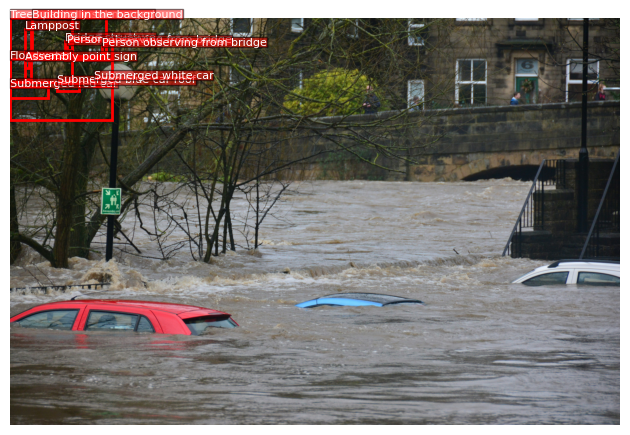

In [27]:
#Testing to see if the provided code works
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json

# Load the image
image_path = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"
im = Image.open(image_path)

# Bounding box data (as generated by the LLM)
bounding_boxes_json = """
[
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]
"""
bounding_boxes = json.loads(bounding_boxes_json)

# Plotting
fig, ax = plt.subplots(1)
ax.imshow(im)
ax.axis('off') # Hide axes

# Add bounding boxes and labels to the plot
for item in bounding_boxes:
    box = item['box_2d']
    label = item['label']
    # The box coordinates are [ymin, xmin, ymax, xmax]
    ymin, xmin, ymax, xmax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add label text slightly above the top-left corner of the box
    plt.text(xmin, ymin - 10, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5, pad=0))


# Display the image
plt.tight_layout()
plt.show()



Attempt 2

In [31]:
#Use the generated bounding boxes to draw on image using code generation
from pprint import pprint

code_exec_prompt = """
Given the following bounding boxes 
bounding_boxes_json = 
[
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]
which were detected from the image image_path = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg",
Generate a python script that will display the bounding boxes on the image
Remember the image path is image_path = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg"

"""



response = client.models.generate_content(
    model=model_name,
    contents=[code_exec_prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    )
)

# response = client.models.generate_content(
#     model='gemini-2.5-pro-exp-03-25',
#     config=config,
#     contents=[code_exec_prompt,image_prompt, im])

for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

```python
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# Bounding box data provided by the user
bounding_boxes_json = [
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]

# Define the image path
image_path = "input_file_0.jpeg" # Use the uploaded file name

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    try:
        # Load the image
        img = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # Define colors for boxes (optional, cycle through colors if needed)
        colors = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta", "white", "lime", "pink"]
        color_index = 0

        # Attempt to load a default font, handle potential errors
        try:
            # Try loading a common font, adjust path if necessary
            # On Kaggle, '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf' might work
            # If not found, it will fall back to the default PIL font
            font = ImageFont.truetype("DejaVuSans-Bold.ttf", 15)
        except IOError:
            print("Default font not found. Using PIL default font.")
            font = ImageFont.load_default()


        # Draw bounding boxes and labels
        for i, bbox_info in enumerate(bounding_boxes_json):
            box = bbox_info['box_2d']
            label = bbox_info['label']
            color = colors[i % len(colors)] # Cycle through colors

            # Draw rectangle: [xmin, ymin, xmax, ymax]
            draw.rectangle(box, outline=color, width=3)

            # Position text slightly below the top-left corner of the box
            text_position = (box[0] + 5, box[1] + 5)
            text_background_position = (box[0], box[1], box[0] + len(label) * 8, box[1] + 20) # Simple estimate for background

            # Draw a small background rectangle for the text for better visibility
            draw.rectangle(text_background_position, fill=color)
            draw.text(text_position, label, fill="black", font=font) # Draw text with black color

        # Display the image using matplotlib
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off') # Hide axes
        plt.title("Image with Bounding Boxes")
        plt.show()

        # Optional: Save the image with bounding boxes
        # output_image_path = "image_with_boxes.jpg"
        # img.save(output_image_path)
        # print(f"Image with bounding boxes saved to {output_image_path}")

    except Exception as e:
        print(f"An error occurred: {e}")
```

```json
[
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge (left)"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge (right)"}
]
```

Default font not found. Using PIL default font.


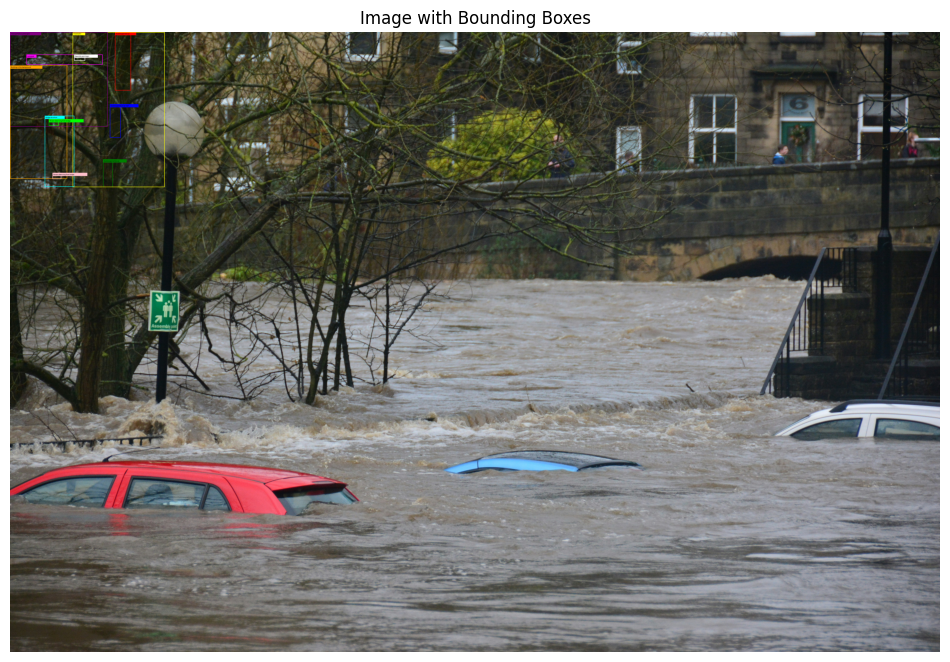

In [35]:
#Test to see if it works
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# Bounding box data provided by the user
bounding_boxes_json = [
  {"box_2d": [677, 0, 780, 376], "label": "Submerged red car"},
  {"box_2d": [644, 465, 714, 681], "label": "Submerged blue car roof"},
  {"box_2d": [600, 821, 663, 1000], "label": "Submerged white car"},
  {"box_2d": [404, 0, 997, 1000], "label": "Floodwater"},
  {"box_2d": [0, 0, 629, 610], "label": "Trees partially submerged"},
  {"box_2d": [0, 216, 368, 946], "label": "Building in the background"},
  {"box_2d": [224, 540, 414, 998], "label": "Bridge structure"},
  {"box_2d": [106, 145, 597, 210], "label": "Lamppost"},
  {"box_2d": [414, 145, 484, 184], "label": "Assembly point sign"},
  {"box_2d": [250, 562, 313, 605], "label": "Person observing from bridge"},
  {"box_2d": [274, 908, 330, 948], "label": "Person observing from bridge"}
]

# Define the image path
image_path = "/kaggle/input/sample-data/chris-gallagher-4zxp5vlmvnI-unsplash.jpg" # Use the uploaded file name

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    try:
        # Load the image
        img = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # Define colors for boxes (optional, cycle through colors if needed)
        colors = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta", "white", "lime", "pink"]
        color_index = 0

        # Attempt to load a default font, handle potential errors
        try:
            # Try loading a common font, adjust path if necessary
            # On Kaggle, '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf' might work
            # If not found, it will fall back to the default PIL font
            font = ImageFont.truetype("DejaVuSans-Bold.ttf", 15)
        except IOError:
            print("Default font not found. Using PIL default font.")
            font = ImageFont.load_default()


        # Draw bounding boxes and labels
        for i, bbox_info in enumerate(bounding_boxes_json):
            box = bbox_info['box_2d']
            label = bbox_info['label']
            color = colors[i % len(colors)] # Cycle through colors

            # Draw rectangle: [xmin, ymin, xmax, ymax]
            draw.rectangle(box, outline=color, width=3)

            # Position text slightly below the top-left corner of the box
            text_position = (box[0] + 5, box[1] + 5)
            text_background_position = (box[0], box[1], box[0] + len(label) * 8, box[1] + 20) # Simple estimate for background

            # Draw a small background rectangle for the text for better visibility
            draw.rectangle(text_background_position, fill=color)
            draw.text(text_position, label, fill="black", font=font) # Draw text with black color

        # Display the image using matplotlib
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off') # Hide axes
        plt.title("Image with Bounding Boxes")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

The provided code runs but in both instances does not align the bounding boxes with the correct features on the image.

### Agents
One approach involves building a user interface (UI) that hosts a chat assistant, designed to gather information directly from users during or after an event. The assistant can then generate a more **informative and comprehensive narrative** based on the user's input.

This has been implemented using the open-source Python package **[Gradio](https://www.gradio.app/)**. Once built, the app can be deployed on platforms like **[Hugging Face Spaces](https://huggingface.co/spaces)**, making it accessible to a wider audience and easy to integrate into a larger disaster response workflow.
The app is available on my **[GenAi_Capstone](https://huggingface.co/spaces/Maritim/GenAi_Capstone)**

This agent helps:
- Collect firsthand incident reports
- Refine user input into structured, analyzable summaries

In [13]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 35.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 88.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00


In [36]:
import gradio as gr


def sentence_builder(Casualties, Event, Location, Time, Situation_Report, Response):
    response_text = "Response is needed urgently." if not Response else "Response efforts in place."
    
    # Incorporate Time and Situation_Report into the output
    return f"""At {Time}, a {Event} occurred in {Location}, affecting approximately {Casualties} people. {Situation_Report}. {response_text}"""


iface = gr.Interface(
    sentence_builder,
    [
        gr.Slider(0, 500, label="Estimated Casualties"),
        gr.Dropdown(["Floods", "Earthquake", "Volcanic eruption", "Gun violence", "Landslides", "Fire"], label="Type of Event"),
        gr.Textbox(label="Location", placeholder="Enter the location"),
        gr.Textbox(label="Time of report", placeholder="Enter the time"),
        gr.Textbox(label="Observation", placeholder="What is the situation"),
        gr.Checkbox(label="Has response been deployed?"),
    ],
    "text",
  
)

iface.launch(pwa=True,share=True)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://330a6cf0812de734a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
